In [1]:
# Importing necessary databases
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Establishing connection to SQLite database
conn = sqlite3.connect('../zippedData/im.db')

## Diagram of Tables

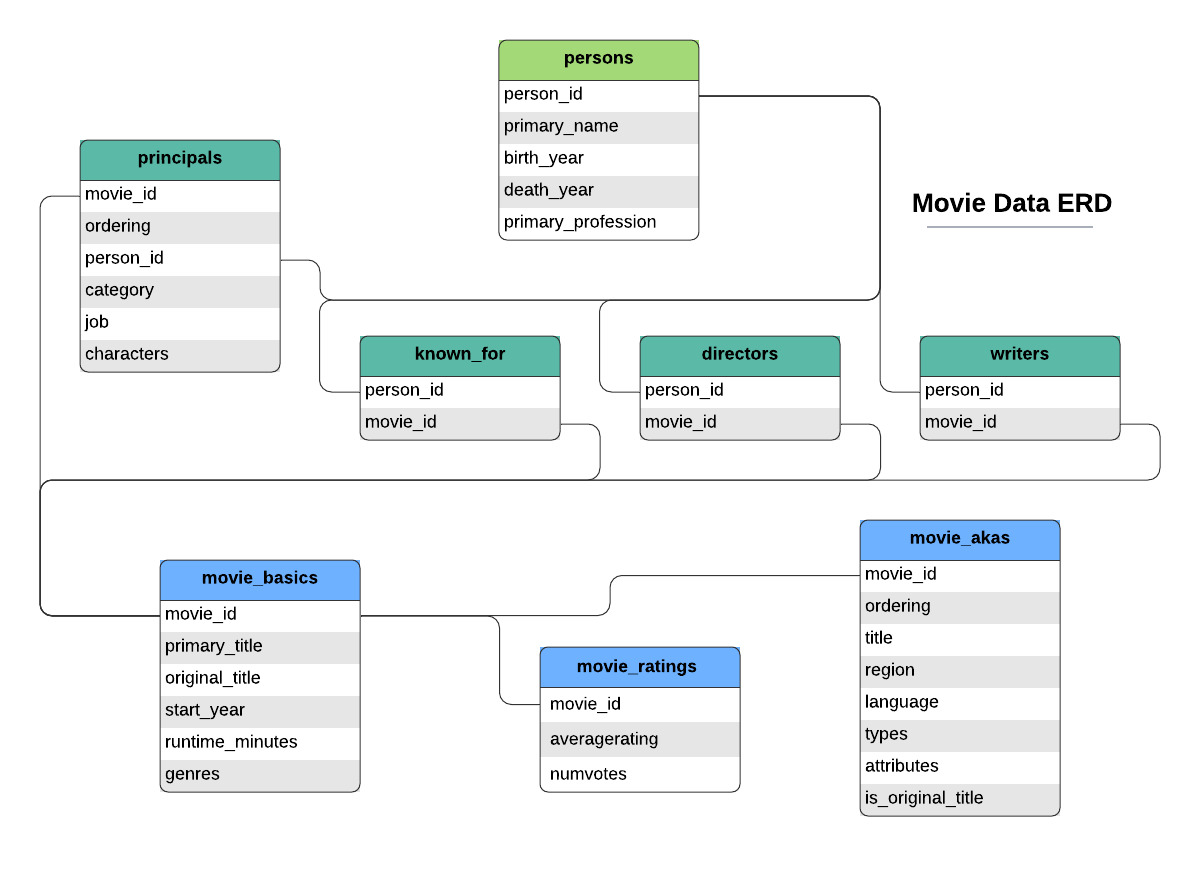

In [3]:
# SQL Query for Movie Basics Table
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics
""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [4]:
# SQL Query for Movie Ratings Table
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings
""", conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [5]:
# SQL Query for Movie Akas Table
movie_akas = pd.read_sql("""
SELECT *
FROM movie_akas
""", conn)
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


## Final SQL Table

In [6]:
# Final SQL Query; calling for all relevant information, joining both Move basics and akas to the movie ratings table using Movie_ID. Then we took movies with over 5,000 votes and ordered the data by average rating in descending order.
imdb_clean_table = pd.read_sql("""
SELECT DISTINCT PRIMARY_TITLE AS Title, AVERAGERATING AS Rating, START_YEAR AS Year, RUNTIME_MINUTES AS Runtime, GENRES AS Genres
FROM MOVIE_RATINGS
JOIN MOVIE_BASICS
    USING(MOVIE_ID)
JOIN MOVIE_AKAS
    USING(MOVIE_ID)
WHERE numvotes > 5000
ORDER BY averagerating DESC
;  
""", conn)
imdb_clean_table

,Title,Rating,Year,Runtime,Genres
0,Once Upon a Time ... in Hollywood,9.7,2019,159.0,"Comedy,Drama"
1,Aloko Udapadi,9.5,2017,113.0,"Drama,History"
2,Peranbu,9.4,2018,147.0,Drama
3,The Mountain II,9.3,2016,135.0,"Action,Drama,War"
4,Aynabaji,9.3,2016,147.0,"Crime,Mystery,Thriller"
...,...,...,...,...,...
3913,Saving Christmas,1.5,2014,79.0,"Comedy,Family"
3914,Code Name: K.O.Z.,1.5,2015,114.0,"Crime,Mystery"
3915,Smolensk,1.4,2016,120.0,"Drama,Thriller"
3916,Potato Salad,1.3,2015,81.0,"Comedy,Horror"


## Combining TMBD and Movie Gross

Here we will combine the TMBD csv, Movie Budget csv and the Movie Gross csv

In [8]:
# Reading movie_gross csv
movie_gross_df = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')

In [10]:
# Reading TMDB csv
tmdb_df = pd.read_csv('../zippedData/tmdb.movies.csv.gz')

In [11]:
# Reading movie_budgets csv
movie_budgets_df = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

In [12]:
# Stripping the commas with white space, removing $ with whitespace and converting to float types.
movie_budgets_df['production_budget'] = movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype('float')
movie_budgets_df['domestic_gross'] = movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype('float')
movie_budgets_df['worldwide_gross'] = movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype('float')

In [13]:
# Calculate the profit and add it as a new column to the movie budgets dataframe
movie_budgets_df['profit'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']

# Sort the dataframe by the profit column in descending order to see the most successful movies
most_profitable_movies = movie_budgets_df.sort_values('profit', ascending=False)

In [14]:
merged_df = movie_gross_df.merge(movie_budgets_df, how='right', left_on='title', right_on='movie')

In [15]:
merged_tmdb_budget = movie_budgets_df.merge(tmdb_df, how='inner', left_on='movie', right_on='title')

Cleaning combined tables

In [16]:
new_merged = merged_tmdb_budget.drop(['original_title'], axis=1)

In [17]:
karl_carolyn_merge = new_merged.drop(['id_x','release_date_x','genre_ids','id_y','Unnamed: 0'], axis=1)

In [18]:
# Creating Quarter Column
karl_carolyn_merge['release_date_y'] = pd.to_datetime(karl_carolyn_merge['release_date_y'])

karl_carolyn_merge['Quarter'] = karl_carolyn_merge['release_date_y'].dt.to_period('Q')

In [19]:
karl_carolyn_merge.rename(columns = {'movie':'Title'},inplace = True)
karl_carolyn_merge.rename(columns = {'profit':'Profit'},inplace = True)
karl_carolyn_merge.rename(columns = {'release_date_y':'Release_Date'},inplace = True)
karl_carolyn_merge.rename(columns = {'production_budget':'Production_Budget'},inplace = True)
karl_carolyn_merge.rename(columns = {'domestic_gross':'Domestic_Gross'},inplace = True)
karl_carolyn_merge.rename(columns = {'worldwide_gross':'Worldwide_Gross'},inplace = True)
karl_carolyn_merge.rename(columns = {'original_language':'Original_Language'},inplace = True)
karl_carolyn_merge.rename(columns = {'popularity':'Popularity'},inplace = True)
karl_carolyn_merge.rename(columns = {'vote_average':'TMDB_Rating'},inplace = True)
karl_carolyn_merge.rename(columns = {'vote_count':'Vote_Count'},inplace = True)

In [20]:
karl_carolyn_merge = karl_carolyn_merge.drop(['title'], axis=1)

In [21]:
# Created new column with Quarter column values as a string
karl_carolyn_merge['Q'] = karl_carolyn_merge['Quarter'].astype(str)
karl_carolyn_merge['Q']

0       2009Q4
1       2011Q2
2       2015Q2
3       2018Q2
4       2017Q4
         ...  
2380    2015Q1
2381    2014Q1
2382    2013Q1
2383    2013Q1
2384    2011Q4
Name: Q, Length: 2385, dtype: object

In [22]:
# Creating a quarter of year column
karl_carolyn_merge['s'] = karl_carolyn_merge['Q'].map( lambda x: x[-1:])
karl_carolyn_merge['s']

0       4
1       2
2       2
3       2
4       4
       ..
2380    1
2381    1
2382    1
2383    1
2384    4
Name: s, Length: 2385, dtype: object

In [23]:
karl_carolyn_merge['Vote_Count'].unique

<bound method Series.unique of 0       18676
1        8571
2       13457
3       13948
4        7510
        ...  
2380      121
2381        5
2382        1
2383       19
2384        7
Name: Vote_Count, Length: 2385, dtype: int64>

In [24]:
karl_carolyn_merge2 = karl_carolyn_merge

In [25]:
# Drops rows with less than 5 votes for ratings
karl_carolyn_merge2.drop(karl_carolyn_merge2[karl_carolyn_merge2.Vote_Count < 5].index, inplace=True)

In [26]:
#karl_carolyn_merge2 = karl_carolyn_merge2.drop(['Quarter'], axis=1)
karl_carolyn_merge2

,Title,Production_Budget,Domestic_Gross,Worldwide_Gross,Profit,Original_Language,Popularity,Release_Date,TMDB_Rating,Vote_Count,Quarter,Q,s
0,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,en,26.526,2009-12-18,7.4,18676,2009Q4,2009Q4,4
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,en,30.579,2011-05-20,6.4,8571,2011Q2,2011Q2,2
2,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,en,44.383,2015-05-01,7.3,13457,2015Q2,2015Q2,2
3,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09,en,80.773,2018-04-27,8.3,13948,2018Q2,2018Q2,2
4,Justice League,300000000.0,229024295.0,6.559452e+08,3.559452e+08,en,34.953,2017-11-17,6.2,7510,2017Q4,2017Q4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,Krisha,30000.0,144822.0,1.448220e+05,1.148220e+05,en,5.288,2016-03-18,6.8,86,2016Q1,2016Q1,1
2380,Exeter,25000.0,0.0,4.897920e+05,4.647920e+05,en,5.934,2015-03-26,4.7,121,2015Q1,2015Q1,1
2381,Ten,25000.0,0.0,0.000000e+00,-2.500000e+04,en,1.575,2014-03-28,5.4,5,2014Q1,2014Q1,1
2383,All Superheroes Must Die,20000.0,0.0,0.000000e+00,-2.000000e+04,en,2.078,2013-01-04,3.9,19,2013Q1,2013Q1,1


In [27]:
# Renaming Column
karl_carolyn_merge2.rename(columns = {'s':'Quarter_Num'},inplace = True)

In [28]:
# Creating Year Column
karl_carolyn_merge2['Year'] = karl_carolyn_merge2['Q'].map( lambda x: x[:4])

In [29]:
# Dropping Column Q
karl_carolyn_merge2 = karl_carolyn_merge2.drop(['Q'], axis=1)

In [30]:
# Dropping Column Quarter
karl_carolyn_merge2 = karl_carolyn_merge2.drop(['Quarter'], axis=1)

In [31]:
# Dropping Release Date
karl_carolyn_merge2 = karl_carolyn_merge2.drop(['Release_Date'], axis=1)

## Final Dataset

In [32]:
# Merging karl_carolyn_merge2 with imdb_clean_table

final_dataset = karl_carolyn_merge2.merge(imdb_clean_table, how='left', left_on='Title', right_on='Title')

In [33]:
# Dropping null values
final_dataset2 = final_dataset.dropna(how="any",axis = 0)

In [34]:
# Pulling the primary genre and creating new column with primary genre
final_dataset2['Genre1']=final_dataset2['Genres'].str.split(",").map(lambda x: x[0])

<ipython-input-34-ad845335369c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset2['Genre1']=final_dataset2['Genres'].str.split(",").map(lambda x: x[0])


In [35]:
# Dropping duplicates Movies
final_dataset2 = final_dataset2.drop_duplicates(subset = ['Title'])

In [36]:
final_dataset2 = final_dataset2[final_dataset2.Genre1 != 'Family']

In [37]:
# Renaming Column from Rating to IMDB Rating;
# Dropping Year_y from the dataset
final_dataset2.rename(columns = {'Rating':'IMDB_Rating'},inplace = True)
final_dataset2 = final_dataset2.drop(['Year_y'], axis=1)

In [38]:
# Changing Year_x to Year
final_dataset2.rename(columns = {'Year_x':'Year'},inplace = True)

In [39]:
# Dropping Genres
final_dataset2 = final_dataset2.drop(['Genres'], axis=1)

## Final Dataset Visualizations

Visualizations for profit by runtime

In [40]:
# Took dataframe of all movies that had a runtime of less than or equal to 90 minutes
less_than_ninety = final_dataset2[final_dataset2['Runtime'] <= 90 ]

In [41]:
# Took dataframe of all movies that had a runtime of greater than 90 but less than or equal to 120 minutes
nintey_to_onetwenty = final_dataset2[(final_dataset2['Runtime'] <= 120) & (final_dataset2['Runtime'] > 90) ]

In [42]:
# Took dataframe of all movies that had a runtime of greater than 120 but less than or equal to 150 minutes
onetwenty_to_onefifty = final_dataset2[(final_dataset2['Runtime'] <= 150) & (final_dataset2['Runtime'] > 120) ]

In [43]:
# Took dataframe of all movies that had a runtime of greater than 150 but less than or equal to 180 minutes
onefifty_to_oneeighty = final_dataset2[(final_dataset2['Runtime'] <= 180) & (final_dataset2['Runtime'] > 150) ]

In [44]:
# Finding the average profit for films with a runtime of less than or equal to 90 minutes
less_than_ninety['Profit'].mean()

57544763.280254774

In [45]:
# Finding the average profit for films with a runtime of greater than 90 but less than or equal to 120 minutes
nintey_to_onetwenty['Profit'].mean()

77664945.10210526

In [46]:
# Finding the average profit for films with a runtime of greater than 120 but less than or equal to 150
onetwenty_to_onefifty['Profit'].mean()

186111242.73722628

In [47]:
# Finding the average profit for films with a runtime of greater than 150 but less than or equal to 180
onefifty_to_oneeighty['Profit'].mean()

288405577.1481481

C:\Users\marcorr\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


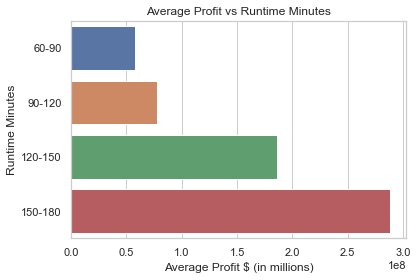

In [48]:
# Creating vertical barplot showing average profit by runtime (in minutes)
x = [57544763.280254774, 77664945.10210526, 186111242.73722628, 288405577.1481481]
y = ['60-90', '90-120', '120-150', '150-180']

sns.barplot(x,y)
plt.title('Average Profit vs Runtime Minutes')
plt.xlabel('Average Profit $ (in millions)')
plt.ylabel('Runtime Minutes')
plt.show()

Visualizations for profits by quarter

In [49]:
# Creating an average profit array
avg_profit_by_qtr = final_dataset2.groupby("Quarter_Num")["Profit"].mean()
profit_by_qrt_array = np.array(avg_profit_by_qtr)
profit_by_qrt_array

array([7.60369214e+07, 1.44140263e+08, 8.84100484e+07, 9.53924537e+07])

C:\Users\marcorr\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


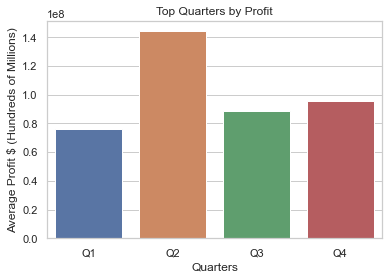

In [50]:
# Created Bar Chart for Top Quarters by Profit 
x1 = ['Q1','Q2','Q3','Q4']
a1 = profit_by_qrt_array

sns.barplot(x1,a1)
plt.title('Top Quarters by Profit')
plt.xlabel('Quarters')
plt.ylabel('Average Profit $ (Hundreds of Millions)')
plt.show()

In [51]:
# Creating an array for quarter counts
count_by_qtr = final_dataset2['Quarter_Num'].value_counts()
count_by_qtr
count_by_qtr_array = np.array(count_by_qtr)

C:\Users\marcorr\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


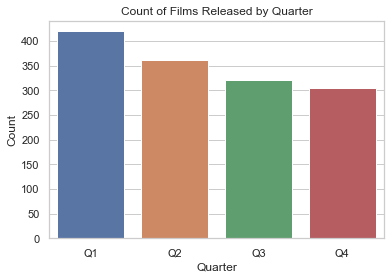

In [52]:
# Created Bar Chart for count of films released by quarter 
x1 = ['Q1','Q2','Q3','Q4']
a1 = count_by_qtr_array

sns.barplot(x1,a1)
plt.title('Count of Films Released by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.show()

In [53]:
# Creating an array for profit by genre
avg_profit_by_genre = final_dataset2.groupby("Genre1")["Profit"].mean()
profit_by_genre_array = np.array(avg_profit_by_genre)
profit_by_genre_array

array([1.69141261e+08, 2.05287285e+08, 2.28436128e+08, 5.16436809e+07,
       4.31219745e+07, 2.91700921e+07, 8.89669025e+06, 4.19814190e+07,
       2.69261404e+07, 6.25169871e+07, 1.38874862e+08, 7.67313250e+07])

In [54]:
# Resorting dataset by profit in descending order
final_dataset2 = final_dataset2.sort_values(by = "Profit",ascending = False)

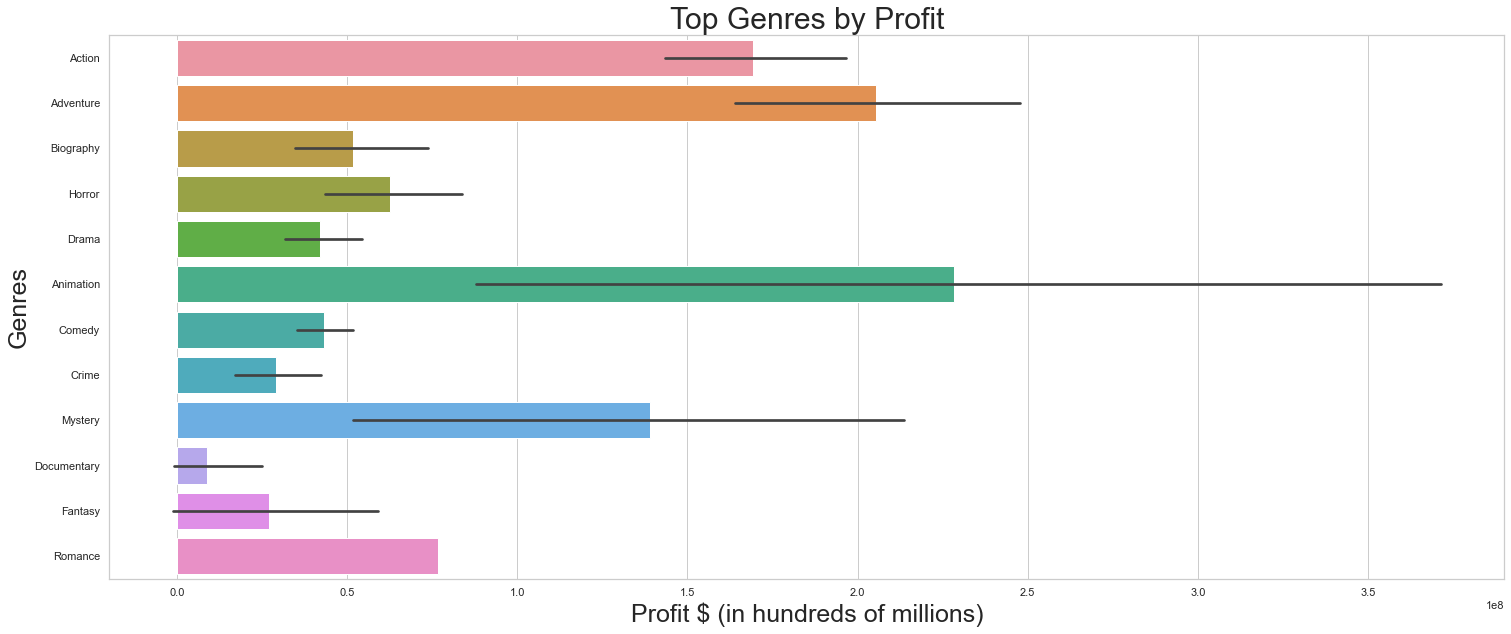

In [55]:
# Horizontal barplot displaying top genres by profit
plt.figure(figsize=(25,10))
sns.barplot(x='Profit', y='Genre1', data=final_dataset2)
sns.set(font_scale=2) 
plt.title('Top Genres by Profit',fontsize = 30)
plt.xlabel('Profit $ (in hundreds of millions)', fontsize = 25)
plt.ylabel('Genres', fontsize = 25)
plt.show()

## Testing

In [56]:
# Gives the correlation coefficient for quantitative variables
final_dataset2.corr()

,Production_Budget,Domestic_Gross,Worldwide_Gross,Profit,Popularity,TMDB_Rating,Vote_Count,IMDB_Rating,Runtime
Production_Budget,1.000000,0.713300,0.788712,0.667517,0.568508,0.098706,0.611083,0.145130,0.368925
Domestic_Gross,0.713300,1.000000,0.942166,0.935881,0.546131,0.235304,0.718135,0.272173,0.304193
Worldwide_Gross,0.788712,0.942166,1.000000,0.984228,0.587603,0.222507,0.731808,0.257534,0.318649
Profit,0.667517,0.935881,0.984228,1.000000,0.548103,0.241095,0.710511,0.270159,0.279781
Popularity,0.568508,0.546131,0.587603,0.548103,1.000000,0.307364,0.691012,0.259863,0.317675
TMDB_Rating,0.098706,0.235304,0.222507,0.241095,0.307364,1.000000,0.413874,0.860751,0.404995
Vote_Count,0.611083,0.718135,0.731808,0.710511,0.691012,0.413874,1.000000,0.409399,0.395081
IMDB_Rating,0.145130,0.272173,0.257534,0.270159,0.259863,0.860751,0.409399,1.000000,0.417667
Runtime,0.368925,0.304193,0.318649,0.279781,0.317675,0.404995,0.395081,0.417667,1.000000


T-test on quarter of the year and average profit

In [57]:
# Run T-Test
sample = final_dataset2[final_dataset2['Quarter_Num']=='2']
# xbar = average for quarter 2
x_bar_final = sample['Profit'].mean()
# mu_final = average profit among all quarters
mu_final = final_dataset2['Profit'].mean()
# standard deviation of the sample population
sigma_final = sample['Profit'].std()
# amount of movies in our sample
n_final = len(sample)

print(x_bar_final, mu_final)

144140262.7795031 100566517.59588069


### Our hypothesis

##### H0: xbar <= mu_final

##### HA: xbar > mu_final

In [58]:
# 95% test
t_final = (x_bar_final -  mu_final)/(sigma_final/np.sqrt(n_final))
t_final

2.9392767585383717

In [59]:
from scipy import stats
import math

In [60]:
# t-value
stats.t.cdf(t_final, df=(n_final-1))

0.9982358370899223

In [61]:
# t-statistic
t_crit = stats.t.ppf(1 - 0.05, df=(n_final-1))
t_crit

1.649614383988715

In [62]:
# (Pushing) p-value
p_value = stats.t.sf(t_final, df = (n_final-1))
p_value

0.0017641629100777615

In [63]:
final_dataset2

,Title,Production_Budget,Domestic_Gross,Worldwide_Gross,Profit,Original_Language,Popularity,TMDB_Rating,Vote_Count,Quarter_Num,Year,IMDB_Rating,Runtime,Genre1
3,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09,en,80.773,8.3,13948,2,2018,8.5,149.0,Action
26,Jurassic World,215000000.0,652270625.0,1.648855e+09,1.433855e+09,en,20.709,6.6,14056,2,2015,7.0,124.0,Action
59,Furious 7,190000000.0,353007020.0,1.518723e+09,1.328723e+09,en,20.396,7.3,6538,2,2015,7.2,137.0,Action
20,The Avengers,225000000.0,623279547.0,1.517936e+09,1.292936e+09,en,50.289,7.6,19673,2,2012,8.1,143.0,Action
37,Black Panther,200000000.0,700059566.0,1.348258e+09,1.148258e+09,en,2.058,5.1,11,1,2011,7.3,134.0,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,The Ridiculous 6,60000000.0,0.0,0.000000e+00,-6.000000e+07,en,10.187,5.0,676,4,2015,4.8,119.0,Comedy
228,Monster Trucks,125000000.0,33370166.0,6.164280e+07,-6.335720e+07,en,8.827,5.9,414,1,2017,5.7,104.0,Action
333,The Promise,90000000.0,8224288.0,1.055142e+07,-7.944858e+07,en,10.158,7.1,195,2,2017,6.1,133.0,Drama
336,Bright,90000000.0,0.0,0.000000e+00,-9.000000e+07,en,15.677,6.2,3181,4,2017,6.4,117.0,Action
